### *CELL 1 — Markdown (purpose)*

# Notebook 03 — Tributary Reconstruction + Monthly→Daily Disaggregation (2001–2021)

## Purpose
Construct a continuous tributary inflow dataset for Lake Victoria over the core study window
(2001-01-01 to 2021-04-27). Tributary time series are monthly and have different coverage periods.

## Strategy 
We combine:
1. Observed monthly tributary flows (where available during 2001–2021)
2. Rainfall-informed reconstruction to extend tributaries outside observation windows:
   - Regression (rain + lags + seasonality) for tributaries with sufficient overlap
   - Historical climatology scaled by rainfall anomaly for tributaries with no overlap
3. Rainfall-weighted monthly→daily disaggregation using CHIRPS daily rainfall

## Inputs (from previous notebooks)
- data/processed/audit_daily_core_variables.csv  (Notebook 01)
- data/processed/tributaries_monthly_wide.csv   (Notebook 02)

## Outputs
- data/processed/tributaries_monthly_reconstructed.csv
- data/processed/Qin_total_daily_2001_2021.csv
- outputs/tables/03_tributary_overlap_classification.csv
- outputs/tables/03_reconstruction_methods.csv
- outputs/figures/03_qin_monthly_consistency_check.png
- outputs/figures/03_obs_vs_recon_*.png (for trainable tributaries)

## Thesis link
Objective 1 (simulate inflows) + provides Qin for Objective 2 (lake water balance) and Objective 3 (optimization).


# Notebook 03 — Tributary Reconstruction + Monthly→Daily Disaggregation (2001–2021)

## Purpose
This notebook constructs a continuous tributary inflow dataset for Lake Victoria over the core study
window (2001-01-01 to 2021-04-27). Tributary time series are provided as monthly flows with different
coverage periods. Some tributaries do not overlap the study window.

## Strategy 
We combine:
1. **Observed monthly tributary flows** (where available in 2001–2021).
2. **Rainfall-informed reconstruction** to fill missing months and to extend tributaries outside their
   observation window.
3. **Rainfall-weighted disaggregation** from monthly flows to daily flows using CHIRPS daily rainfall.

## Reconstruction methods used
- **Group A: Overlap exists (>= 24 months overlap)**  
  Train a regression model using monthly rainfall predictors and seasonal terms to predict flows.
- **Group B: No overlap with 2001–2021 (Nyando, Nzoia, Yala)**  
  Use historical monthly climatology scaled by rainfall anomaly during 2001–2021.

## Outputs
- Monthly reconstructed tributary flows (all 15) for 2001-01 to 2021-04
- Daily total inflow Qin for lake water balance model

## Thesis link (Chapter 4)
Supports Objective 1 (simulate inflows) and provides Qin for Objective 2–3 (lake balance + optimization).


### *CELL 2 — Imports + paths*

In [1]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
FIG_DIR = PROJECT_ROOT / "outputs" / "figures"
TABLE_DIR = PROJECT_ROOT / "outputs" / "tables"

for folder in [PROCESSED_DIR, FIG_DIR, TABLE_DIR]:
    folder.mkdir(parents=True, exist_ok=True)

AUDIT_DAILY_PATH = PROCESSED_DIR / "audit_daily_core_variables.csv"
TRIB_WIDE_PATH = PROCESSED_DIR / "tributaries_monthly_wide.csv"


### *CELL 3 — Reference utilities (from Notebook 01 & 02)*

These are the “important parts” you requested: robust date parsing + safe loading.

In [2]:
def _try_parse_dates(s: pd.Series, dayfirst: bool) -> pd.Series:
    """Try parsing dates with a specific dayfirst setting."""
    return pd.to_datetime(
        s.astype(str).str.strip(),
        errors="coerce",
        dayfirst=dayfirst,
        infer_datetime_format=True,
    )


def parse_date_series(date_series: pd.Series) -> pd.DatetimeIndex:
    """
    Robust date parsing for mixed formats:
    - 01/12/1956 could be DD/MM or MM/DD
    - 1/13/1956 must be MM/DD
    Strategy:
    - parse with dayfirst=False and dayfirst=True
    - choose the parse with fewer NaT values
    """
    dt_mdy = _try_parse_dates(date_series, dayfirst=False)
    dt_dmy = _try_parse_dates(date_series, dayfirst=True)

    mdy_nat = dt_mdy.isna().mean()
    dmy_nat = dt_dmy.isna().mean()

    if (mdy_nat == 1.0) and (dmy_nat == 1.0):
        bad = date_series.astype(str).head(10).tolist()
        raise ValueError(f"Date parsing failed completely. Examples: {bad}")

    dt = dt_mdy if mdy_nat <= dmy_nat else dt_dmy

    if dt.isna().any():
        bad = date_series.astype(str)[dt.isna()].head(10).tolist()
        raise ValueError(
            "Date parsing failed for some rows. Examples:\n"
            f"{bad}"
        )

    return pd.DatetimeIndex(dt)


def load_csv_with_date_index(path: Path) -> pd.DataFrame:
    """
    Load a CSV and robustly identify the date column.
    Handles cases where the date was saved as index (e.g., 'Unnamed: 0').
    """
    df = pd.read_csv(path)

    # If a clean 'date' column exists, use it
    if "date" in df.columns:
        dt = parse_date_series(df["date"])
        df = df.drop(columns=["date"])
        df.index = dt
        return df.sort_index()

    # Common pandas artifact if index was saved
    for c in ["Unnamed: 0", "index", "Date"]:
        if c in df.columns:
            dt = parse_date_series(df[c])
            df = df.drop(columns=[c])
            df.index = dt
            return df.sort_index()

    # Fallback: assume first column is date
    first = df.columns[0]
    dt = parse_date_series(df[first])
    df = df.drop(columns=[first])
    df.index = dt
    return df.sort_index()


### *CELL 4 — Load inputs safely + diagnostics*

In [3]:
audit_daily = load_csv_with_date_index(AUDIT_DAILY_PATH)
trib_wide = load_csv_with_date_index(TRIB_WIDE_PATH)

print("audit_daily columns:", audit_daily.columns.tolist())
print("audit_daily range:", audit_daily.index.min().date(), "to", audit_daily.index.max().date(), "n=", len(audit_daily))

print("\ntributary columns (n):", len(trib_wide.columns))
print("tributary range:", trib_wide.index.min().date(), "to", trib_wide.index.max().date(), "n=", len(trib_wide))
print("First 5 tributaries:", trib_wide.columns.tolist()[:5])


audit_daily columns: ['rainfall_mm', 'evap_mm', 'outflow_m3s', 'lake_level_m']
audit_daily range: 2001-01-01 to 2021-04-27 n= 7422

tributary columns (n): 15
tributary range: 1965-01-01 to 2023-12-01 n= 708
First 5 tributaries: ['Awach', 'Grumeti', 'Kagera', 'Katonga', 'Magogo']


C:\Users\Nelson\AppData\Local\Temp\ipykernel_31192\1793728792.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(
C:\Users\Nelson\AppData\Local\Temp\ipykernel_31192\1793728792.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(
C:\Users\Nelson\AppData\Local\Temp\ipykernel_31192\1793728792.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.

### *CELL 5 — Standardize rainfall column name (guardrail)*

In [4]:
def pick_rainfall_column(df: pd.DataFrame) -> str:
    """Find rainfall column by common names used in our pipeline."""
    candidates = ["rainfall_mm", "Average_pcp_mm/day", "Average_pcp"]
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(
        "Could not find rainfall column. Found columns:\n"
        f"{df.columns.tolist()}"
    )


rain_col = pick_rainfall_column(audit_daily)
rain_daily = audit_daily[rain_col].copy()


### *CELL 6 — Study window (fixed from your successful Notebook 01)*

In [5]:
STUDY_START = pd.Timestamp("2001-01-01")
STUDY_END = pd.Timestamp("2021-04-27")

monthly_idx = pd.date_range(STUDY_START, STUDY_END, freq="MS")
rain_daily = rain_daily.loc[STUDY_START:STUDY_END].copy()

print("Study window:", STUDY_START.date(), "to", STUDY_END.date(), "days:", len(rain_daily))
print("Monthly index length:", len(monthly_idx))


Study window: 2001-01-01 to 2021-04-27 days: 7422
Monthly index length: 244


### *CELL 7 — Build monthly rainfall predictors (rain totals + lags + seasonality)*

In [6]:
def build_monthly_rain_predictors(
    rain_daily_mm: pd.Series,
    idx_monthly: pd.DatetimeIndex,
) -> pd.DataFrame:
    """Create monthly rainfall predictors with lags and seasonal dummies."""
    rain_m = rain_daily_mm.resample("MS").sum(min_count=1).reindex(idx_monthly)

    x = pd.DataFrame(index=idx_monthly)
    x["rain_m0"] = rain_m
    x["rain_m1"] = rain_m.shift(1)
    x["rain_m2"] = rain_m.shift(2)

    # Month seasonality (one-hot, drop_first)
    month_dummies = pd.get_dummies(idx_monthly.month, prefix="mo", drop_first=True)
    month_dummies.index = idx_monthly
    x = pd.concat([x, month_dummies], axis=1)

    return x


X_rain = build_monthly_rain_predictors(rain_daily, monthly_idx)
X_rain.head()


,rain_m0,rain_m1,rain_m2,mo_2,mo_3,mo_4,mo_5,mo_6,mo_7,mo_8,mo_9,mo_10,mo_11,mo_12
2001-01-01,112.106991,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False
2001-02-01,65.338277,112.106991,NaN,True,False,False,False,False,False,False,False,False,False,False
2001-03-01,179.856445,65.338277,112.106991,False,True,False,False,False,False,False,False,False,False,False
2001-04-01,214.352516,179.856445,65.338277,False,False,True,False,False,False,False,False,False,False,False
2001-05-01,182.640783,214.352516,179.856445,False,False,False,True,False,False,False,False,False,False,False


### *CELL 8 — Tributary overlap classification (for choosing regression vs climatology)*

In [7]:
def to_month_start_index(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure monthly index is month-start timestamps (MS)."""
    dt = pd.to_datetime(df.index, errors="coerce")

    if dt.isna().any():
        bad = df.index[pd.isna(dt)].astype(str)[:10].tolist()
        raise ValueError(f"Non-parseable dates in index. Examples: {bad}")

    idx = dt.to_period("M").to_timestamp(how="start")  #  month start
    out = df.copy()
    out.index = idx

    # If duplicates happen after collapsing to monthly, average them
    out = out.groupby(out.index).mean(numeric_only=True)

    return out.sort_index()


trib_wide = to_month_start_index(trib_wide)

print("trib_wide index freq-ish:", pd.infer_freq(trib_wide.index[:12]))
print("min/max:", trib_wide.index.min(), "->", trib_wide.index.max())



def overlap_months(series: pd.Series, idx: pd.DatetimeIndex) -> int:
    s = series.reindex(idx)
    return int(s.notna().sum())


overlap_counts = {
    trib: overlap_months(trib_wide[trib], monthly_idx)
    for trib in trib_wide.columns
}

overlap_df = (
    pd.DataFrame(
        {"tributary": list(overlap_counts.keys()),
         "overlap_months": list(overlap_counts.values())}
    )
    .sort_values("overlap_months")
    .reset_index(drop=True)
)

# Threshold to train a regression (tunable; 24 months is conservative)
overlap_df["trainable_regression"] = overlap_df["overlap_months"] >= 24
overlap_df.to_csv(TABLE_DIR / "03_tributary_overlap_classification.csv", index=False)

overlap_df.head(10)


trib_wide index freq-ish: MS
min/max: 1965-01-01 00:00:00 -> 2023-12-01 00:00:00


,tributary,overlap_months,trainable_regression
0,Nzoia,0,False
1,Yala,0,False
2,Nyando,0,False
3,Katonga,96,True
4,Rwizi,119,True
5,Mbalangeti,144,True
6,Grumeti,180,True
7,Kagera,192,True
8,Sio_Malaba,204,True
9,Simiyu,216,True


`Quick check to confirm why those 3 are zero`

In [8]:
for t in ["Nzoia", "Yala", "Nyando"]:
    s = trib_wide[t]
    print(t, "series range:", s.dropna().index.min(), "->", s.dropna().index.max())
print("monthly_idx range:", monthly_idx.min(), "->", monthly_idx.max())


Nzoia series range: 1976-01-01 00:00:00 -> 1989-12-01 00:00:00
Yala series range: 1971-01-01 00:00:00 -> 1990-11-01 00:00:00
Nyando series range: 1965-01-01 00:00:00 -> 1993-12-01 00:00:00
monthly_idx range: 2001-01-01 00:00:00 -> 2021-04-01 00:00:00


### *CELL 9 — Reconstruction methods (regression or climatology×rain anomaly)*

In [9]:
@dataclass
class ReconResult:
    tributary: str
    method: str
    rmse: float | None
    n_train: int
    n_pred: int


def fit_predict_ridge(
    y: pd.Series,
    X: pd.DataFrame,
    idx: pd.DatetimeIndex,
    alpha: float = 2.0,
) -> Tuple[pd.Series, float, int]:
    """
    Fit Ridge regression on available months and predict for full idx.
    Uses log1p transform for stability and non-negativity tendency.

    Robust to NaNs in lag features (e.g., rain_m1/rain_m2 at the start).
    """
    y_i = y.reindex(idx).astype(float)
    X_i = X.reindex(idx).copy()

    # --- 1) Make sure predictors used for prediction contain no NaNs ---
    # Lag features have NaNs at the start due to shifting. Fill them safely.
    lag_cols = [c for c in X_i.columns if c.startswith("rain_m")]
    if lag_cols:
        X_i[lag_cols] = X_i[lag_cols].fillna(0.0)

    # (Month dummies should be complete already, but just in case:)
    X_i = X_i.fillna(0.0)

    # --- 2) Train only where y exists AND all predictors exist ---
    train_mask = y_i.notna() & X_i.notna().all(axis=1)

    n_train = int(train_mask.sum())
    if n_train < 24:
        raise ValueError(f"Not enough training months for regression: n_train={n_train}")

    X_train = X_i.loc[train_mask].values
    y_train = y_i.loc[train_mask].values

    # log1p transform
    y_train_t = np.log1p(np.clip(y_train, 0.0, None))

    # NOTE: Ridge(random_state=...) is not always supported depending on solver/version
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train_t)

    y_hat_t = model.predict(X_i.values)
    y_hat = np.expm1(y_hat_t)
    y_hat = pd.Series(y_hat, index=idx).clip(lower=0.0)

    rmse = float(np.sqrt(mean_squared_error(y_train, y_hat.loc[train_mask].values)))
    return y_hat, rmse, n_train



def reconstruct_climatology_scaled(
    y_hist: pd.Series,
    X: pd.DataFrame,
    idx: pd.DatetimeIndex,
    power: float = 1.0,
    clip_low: float = 0.25,
    clip_high: float = 3.0,
) -> pd.Series:
    """
    Reconstruct using historical month-of-year climatology scaled by rainfall anomaly:
        Q(m) = clim_Q(month) * (rain(m) / mean_rain(month))^power
    """
    y_hist = y_hist.dropna()
    if y_hist.empty:
        raise ValueError("No historical data for climatology reconstruction.")

    clim_q = y_hist.groupby(y_hist.index.month).mean()

    rain_m = X.reindex(idx)["rain_m0"]
    rain_clim = rain_m.groupby(rain_m.index.month).mean()

    ratio_vals = []
    for d in idx:
        m = d.month
        denom = rain_clim.loc[m]
        num = rain_m.loc[d]

        if pd.isna(num) or pd.isna(denom) or denom <= 0:
            ratio_vals.append(1.0)
        else:
            ratio_vals.append(float(num / denom))

    ratio = pd.Series(ratio_vals, index=idx).replace([np.inf, -np.inf], np.nan).fillna(1.0)
    ratio = (ratio.clip(lower=clip_low, upper=clip_high) ** power)

    q_base = pd.Series([clim_q.loc[d.month] for d in idx], index=idx)
    return (q_base * ratio).clip(lower=0.0)


In [10]:
print("X columns:", X_rain.columns.tolist())
print("Any NaNs in X_rain?", X_rain.isna().any().any())
print("NaN % by column:\n", (X_rain.isna().mean() * 100).round(2))


X columns: ['rain_m0', 'rain_m1', 'rain_m2', 'mo_2', 'mo_3', 'mo_4', 'mo_5', 'mo_6', 'mo_7', 'mo_8', 'mo_9', 'mo_10', 'mo_11', 'mo_12']
Any NaNs in X_rain? True
NaN % by column:
 rain_m0    0.00
rain_m1    0.41
rain_m2    0.82
mo_2       0.00
mo_3       0.00
mo_4       0.00
mo_5       0.00
mo_6       0.00
mo_7       0.00
mo_8       0.00
mo_9       0.00
mo_10      0.00
mo_11      0.00
mo_12      0.00
dtype: float64


### *CELL 10 — Reconstruct all tributaries (monthly)*

In [ ]:
recon_monthly = pd.DataFrame(index=monthly_idx)
recon_meta: List[ReconResult] = []

def ensure_month_start(idx_like) -> pd.DatetimeIndex:
    """Force any datetime-like index to month-start timestamps."""
    dt = pd.to_datetime(idx_like)
    return dt.to_period("M").to_timestamp(how="start")

for trib in trib_wide.columns:
    y = trib_wide[trib].copy()
    y.index = ensure_month_start(y.index)
    y = y.groupby(y.index).mean()  # safety: merge duplicates if any
    y = y.sort_index()

    # Is this tributary trainable for regression?
    is_trainable = bool(
        overlap_df.loc[overlap_df["tributary"] == trib, "trainable_regression"].iloc[0]
    )

    if is_trainable:
        y_hat, rmse, n_train = fit_predict_ridge(
            y=y, X=X_rain, idx=monthly_idx, alpha=2.0
        )

        # Use observed values where available (within study window)
        y_obs = y.reindex(monthly_idx)
        y_full = y_hat.copy()
        y_full.loc[y_obs.notna()] = y_obs.loc[y_obs.notna()]

        recon_monthly[trib] = y_full
        recon_meta.append(
            ReconResult(trib, "ridge_rain_seasonality_log1p", rmse, n_train, len(monthly_idx))
        )

    else:
        y_full = reconstruct_climatology_scaled(
            y_hist=y,
            X=X_rain,
            idx=monthly_idx,
            power=1.0,
        )
        recon_monthly[trib] = y_full
        recon_meta.append(
            ReconResult(trib, "climatology_scaled_by_rain", None, 0, len(monthly_idx))
        )

# Final clean + save outputs
recon_monthly = recon_monthly.clip(lower=0.0)

recon_meta_df = (
    pd.DataFrame([r.__dict__ for r in recon_meta])
    .sort_values(["method", "tributary"])
    .reset_index(drop=True)
)

recon_monthly.to_csv(PROCESSED_DIR / "tributaries_reconstructed_monthly.csv")
recon_meta_df.to_csv(TABLE_DIR / "03_reconstruction_methods.csv", index=False)

recon_monthly.head(), recon_meta_df.head()


(                Awach    Grumeti      Kagera   Katonga     Magogo  Mbalangeti  \
 2001-01-01   4.849570  10.503936  204.822159  2.895328   6.200375    5.174444   
 2001-02-01   2.710548   8.065574  262.262683  3.548916   4.221598    5.385892   
 2001-03-01   4.347851   9.759940  303.866305  2.870644   6.259091   10.036095   
 2001-04-01   7.125828  13.623871  343.950301  3.621237   9.025261   10.088658   
 2001-05-01  10.522547  17.082993  296.394801  6.956099  13.630161   11.654450   
 
                Migori      Mori     Nyando       Nzoia    Rwizi     Simiyu  \
 2001-01-01  39.616365  3.852642  43.542121   51.544048  17.8047   6.421914   
 2001-02-01  35.441512  4.508692  25.775063   32.737746   5.7670   3.427360   
 2001-03-01  65.616207  6.246192  32.273174   45.886174   6.8037   8.070072   
 2001-04-01  57.614743  6.075831  28.109800   67.497747  19.8665   9.134079   
 2001-05-01  62.346702  6.192868  31.470485  121.767007  11.6496  18.848658   
 
             Sio_Malaba      S

*Sanity check:If `Any NaNs? False` → then fully clean for Notebook 04 onward.*

In [ ]:
print("Shape:", recon_monthly.shape)
print("Any NaNs?", recon_monthly.isna().any().any())
print("Min (overall):", float(recon_monthly.min().min()))
print("Max (overall):", float(recon_monthly.max().max()))
print("NaN count by tributary (top 5):")
print(recon_monthly.isna().sum().sort_values(ascending=False).head(5))


Shape: (244, 15)
Any NaNs? False
Min (overall): 0.00755844
Max (overall): 1258.2249
NaN count by tributary (top 5):
Awach      0
Grumeti    0
Kagera     0
Katonga    0
Magogo     0
dtype: int64


### *CELL 11 — Validation plots (observed vs reconstructed where trainable)*

In [ ]:
def plot_obs_vs_recon_monthly(
    trib: str,
    y_obs: pd.Series,
    y_recon: pd.Series,
    outpath: Path,
) -> None:
    """Plot observed vs reconstructed monthly flow."""
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.plot(y_recon.index, y_recon.values, label="Reconstructed", linewidth=1.5)
    ax.scatter(y_obs.index, y_obs.values, label="Observed", s=12)
    ax.set_title(f"Monthly Flow — Observed vs Reconstructed ({trib})")
    ax.set_xlabel("Date")
    ax.set_ylabel("Flow (m³/s)")
    ax.grid(True, alpha=0.3)
    ax.legend()
    fig.tight_layout()
    fig.savefig(outpath, dpi=200)
    plt.close(fig)


for row in recon_meta_df.itertuples(index=False):
    if row.method.startswith("ridge"):
        trib = row.tributary
        y_obs = trib_wide[trib].reindex(monthly_idx).dropna()
        y_recon = recon_monthly[trib]
        plot_obs_vs_recon_monthly(
            trib=trib,
            y_obs=y_obs,
            y_recon=y_recon,
            outpath=FIG_DIR / f"03_obs_vs_recon_{trib}.png",
        )

print("Saved observed-vs-reconstructed plots for regression-trainable tributaries.")


Saved observed-vs-reconstructed plots for regression-trainable tributaries.


### *CELL 12 — Total monthly Qin + save monthly reconstructed tributaries*

In [ ]:
trib_cols = [c for c in recon_monthly.columns if c != "Qin_total_m3s"]
recon_monthly["Qin_total_m3s"] = recon_monthly[trib_cols].sum(axis=1)
recon_monthly.to_csv(PROCESSED_DIR / "tributaries_monthly_reconstructed.csv", index=True)

print("Saved:", PROCESSED_DIR / "tributaries_monthly_reconstructed.csv")
print("Mean total Qin (monthly mean m3/s):", float(recon_monthly["Qin_total_m3s"].mean()))


Saved: c:\Users\Nelson\Downloads\LakeVictoria_Optimization\data\processed\tributaries_monthly_reconstructed.csv
Mean total Qin (monthly mean m3/s): 651.830520654764


In [ ]:
recon_monthly["Qin_total_m3s"].describe()


count     244.000000
mean      651.830521
std       237.997793
min       289.999747
25%       480.791819
50%       597.360842
75%       783.081915
max      1758.096195
Name: Qin_total_m3s, dtype: float64

### *CELL 13 — Monthly→Daily rainfall-weighted disaggregation (volume-consistent)*

In [ ]:
def disaggregate_monthly_to_daily_rain_weighted(
    q_monthly_m3s: pd.Series,
    rain_daily_mm: pd.Series,
    start: pd.Timestamp,
    end: pd.Timestamp,
) -> pd.Series:
    """
    Rainfall-weighted monthly→daily disaggregation.

    q_monthly_m3s is treated as MONTHLY MEAN discharge (m³/s) at month-start timestamps.
    Daily disaggregation is constructed so that when daily is averaged back to monthly,
    the monthly mean approximately matches the original q_monthly_m3s.

    If a month has zero rainfall, uniform weights are used.
    """
    daily_idx = pd.date_range(start, end, freq="D")
    q_daily = pd.Series(index=daily_idx, dtype=float)

    rain_daily_mm = rain_daily_mm.reindex(daily_idx).fillna(0.0)

    for month_start, q_m in q_monthly_m3s.items():
        ms = pd.Timestamp(month_start)
        me = (ms + pd.offsets.MonthBegin(1)) - pd.Timedelta(days=1)

        # Clip month to the study window
        ms_clip = max(ms, start)
        me_clip = min(me, end)

        days = pd.date_range(ms_clip, me_clip, freq="D")
        if len(days) == 0:
            continue

        rain_slice = rain_daily_mm.loc[days]
        rain_sum = float(rain_slice.sum())

        if rain_sum > 0:
            w = rain_slice / rain_sum
        else:
            w = pd.Series(1.0 / len(days), index=days)

        # Preserve monthly mean: distribute such that mean of daily ≈ q_m
        q_daily.loc[days] = float(q_m) * w.values * len(days)

    return q_daily.clip(lower=0.0)


qin_monthly = recon_monthly["Qin_total_m3s"].copy()
qin_daily = disaggregate_monthly_to_daily_rain_weighted(
    q_monthly_m3s=qin_monthly,
    rain_daily_mm=rain_daily,
    start=STUDY_START,
    end=STUDY_END,
)

qin_daily.to_csv(PROCESSED_DIR / "Qin_total_daily_2001_2021.csv", index=True)
print("Saved:", PROCESSED_DIR / "Qin_total_daily_2001_2021.csv")
print(qin_daily.head())


Saved: c:\Users\Nelson\Downloads\LakeVictoria_Optimization\data\processed\Qin_total_daily_2001_2021.csv
2001-01-01    444.060046
2001-01-02    165.032384
2001-01-03    217.182355
2001-01-04    629.047275
2001-01-05    283.677573
Freq: D, dtype: float64


### *CELL 14 — Consistency check plot (monthly mean vs daily→monthly)*

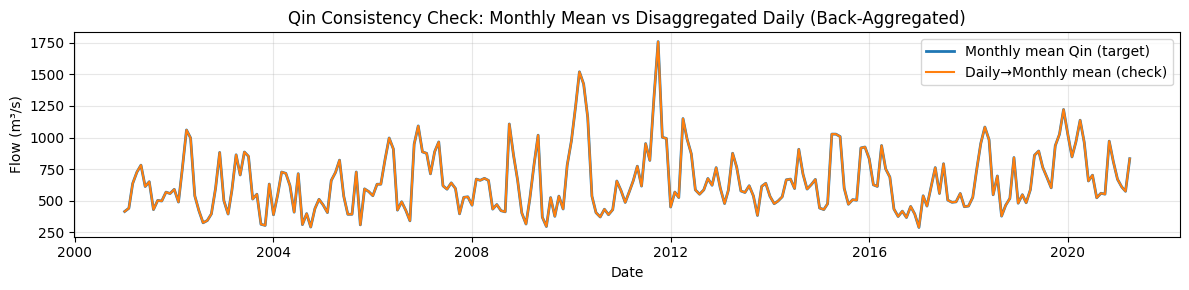

In [ ]:
qin_daily_monthly_mean = qin_daily.resample("MS").mean().reindex(monthly_idx)

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(qin_monthly.index, qin_monthly.values, label="Monthly mean Qin (target)", linewidth=2)
ax.plot(qin_daily_monthly_mean.index, qin_daily_monthly_mean.values, label="Daily→Monthly mean (check)", linewidth=1.5)
ax.set_title("Qin Consistency Check: Monthly Mean vs Disaggregated Daily (Back-Aggregated)")
ax.set_xlabel("Date")
ax.set_ylabel("Flow (m³/s)")
ax.grid(True, alpha=0.3)
ax.legend()
fig.tight_layout()
fig.savefig(FIG_DIR / "03_qin_monthly_consistency_check.png", dpi=200)
plt.show()


`Numeric consistency check`

In [ ]:
qin_daily_monthly_mean = qin_daily.resample("MS").mean().reindex(monthly_idx)
diff = (qin_daily_monthly_mean - qin_monthly.reindex(monthly_idx)).abs()

print("Max abs monthly-mean diff:", float(diff.max()))
print("Mean abs monthly-mean diff:", float(diff.mean()))
print("Months with diff > 1e-6:", int((diff > 1e-6).sum()))


Max abs monthly-mean diff: 4.547473508864641e-13
Mean abs monthly-mean diff: 6.70938714422652e-14
Months with diff > 1e-6: 0


### *CELL 15 — Thesis-ready summary paragraph (saved)*

In [ ]:
summary_text = (
    "Monthly tributary inflows for 15 Lake Victoria tributaries were available with varying record lengths. "
    "To obtain a continuous inflow series consistent with the daily lake water balance period (2001–2021), "
    "tributary flows were reconstructed using rainfall-informed methods. Tributaries with sufficient overlap "
    "were modeled using a regression relationship between monthly rainfall totals, lagged rainfall, and "
    "seasonality. Tributaries without overlap were represented using historical monthly climatology scaled "
    "by rainfall anomalies during the study period. The reconstructed monthly inflows were then disaggregated "
    "to daily flows using rainfall-weighted allocation, preserving monthly mean discharge while reflecting "
    "intra-month variability driven by rainfall."
)

(TABLE_DIR / "03_reconstruction_summary.txt").write_text(summary_text, encoding="utf-8")
print(summary_text)


Monthly tributary inflows for 15 Lake Victoria tributaries were available with varying record lengths. To obtain a continuous inflow series consistent with the daily lake water balance period (2001–2021), tributary flows were reconstructed using rainfall-informed methods. Tributaries with sufficient overlap were modeled using a regression relationship between monthly rainfall totals, lagged rainfall, and seasonality. Tributaries without overlap were represented using historical monthly climatology scaled by rainfall anomalies during the study period. The reconstructed monthly inflows were then disaggregated to daily flows using rainfall-weighted allocation, preserving monthly mean discharge while reflecting intra-month variability driven by rainfall.


`"Monthly tributary inflows for 15 Lake Victoria tributaries were available with varying record lengths. "
    "To obtain a continuous inflow series consistent with the daily lake water balance period (2001–2021), "
    "tributary flows were reconstructed using rainfall-informed methods. Tributaries with sufficient overlap "
    "were modeled using a regression relationship between monthly rainfall totals, lagged rainfall, and "
    "seasonality. Tributaries without overlap were represented using historical monthly climatology scaled "
    "by rainfall anomalies during the study period. The reconstructed monthly inflows were then disaggregated "
    "to daily flows using rainfall-weighted allocation, preserving monthly mean discharge while reflecting "
    "intra-month variability driven by rainfall."`